# Ekstraksi dataset dari ZIP

Kita hanya mengekstrak 200 gambar grayscale dan color dari arsip ZIP, dan menyimpannya ke folder `gray/` dan `color/` secara terpisah. Hal ini dilakukan guna efisiensi sumber daya komputasi.

In [ ]:
import zipfile
import os

zip_path = '/content/drive/MyDrive/Dataset Colorization Images/archive.zip'
extract_base = '/content/drive/MyDrive/Dataset Colorization Images'

gray_target = os.path.join(extract_base, 'gray')
color_target = os.path.join(extract_base, 'color')

os.makedirs(gray_target, exist_ok=True)
os.makedirs(color_target, exist_ok=True)

selected_files = [f"{i}.jpg" for i in range(1, 201)]  # 1.jpg sampai 200.jpg

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    for member in zip_ref.namelist():
        for fname in selected_files:
            # Cek apakah path-nya cocok dengan file yang ingin diambil
            if member.endswith(f'gray/{fname}'):
                zip_ref.extract(member, extract_base)
                os.rename(
                    os.path.join(extract_base, member),
                    os.path.join(gray_target, fname)
                )
            elif member.endswith(f'color/{fname}'):
                zip_ref.extract(member, extract_base)
                os.rename(
                    os.path.join(extract_base, member),
                    os.path.join(color_target, fname)
                )

print("Ekstraksi selesai.")

Ekstraksi selesai.


# Import library dan konfigurasi global

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, Input, Model
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 8
EPOCHS = 50

GRAY_DIR = '/content/drive/MyDrive/Dataset Colorization Images/gray'
COLOR_DIR = '/content/drive/MyDrive/Dataset Colorization Images/color'

# Load dan preprocessing gambar

In [ ]:
N_SAMPLES = 200

gray_paths = sorted([os.path.join(GRAY_DIR, f)
                     for f in os.listdir(GRAY_DIR)
                     if f.lower().endswith(('.jpg', '.jpeg', '.png'))])[:N_SAMPLES]

color_paths = sorted([os.path.join(COLOR_DIR, f)
                      for f in os.listdir(COLOR_DIR)
                      if f.lower().endswith(('.jpg', '.jpeg', '.png'))])[:N_SAMPLES]

In [ ]:
gray_list, color_list, meta = [], [], []

for g_path, c_path in zip(gray_paths, color_paths):
    if os.path.basename(g_path) != os.path.basename(c_path):
        print(f"Mismatch: {g_path} vs {c_path}")
    gray = cv2.imread(g_path, cv2.IMREAD_GRAYSCALE)
    color = cv2.imread(c_path, cv2.IMREAD_COLOR)

    if gray is None or color is None:
        print(f"Skipped corrupted: {g_path} or {c_path}")
        continue

    # Simpan metadata
    h, w = gray.shape
    meta.append([os.path.basename(g_path), h, w])

    # Resize
    gray = cv2.resize(gray, (IMG_SIZE, IMG_SIZE))
    color = cv2.resize(color, (IMG_SIZE, IMG_SIZE))

    # Normalize
    gray = gray.astype(np.float32) / 255.0
    color = color.astype(np.float32) / 255.0

    # Expand dim grayscale
    gray = np.expand_dims(gray, axis=-1)

    gray_list.append(gray)
    color_list.append(color)

In [ ]:
# Simpan metadata ke DataFrame
df = pd.DataFrame(meta, columns=["filename", "height", "width"])
print(f"Loaded {len(df)} image pairs.")

Loaded 200 image pairs.


In [ ]:
df.head()

filename  height  width
0    1.jpg     150    150
1   10.jpg     150    150
2  100.jpg     150    150
3  101.jpg     150    150
4  102.jpg     150    150

# Simpan dan load kembali array numpy of images

Menyimpan array NumPy hasil preprocessing agar bisa digunakan kembali tanpa proses ulang.

In [ ]:
gray_np = np.array(gray_list)
color_np = np.array(color_list)

Train: 160, Val: 20, Test: 20


In [ ]:
save_dir = "/content/drive/MyDrive/Dataset Colorization Images"

# Simpan array satu per satu
np.save(f"{save_dir}/gray_np.npy", gray_np)
np.save(f"{save_dir}/color_np.npy", color_np)

In [ ]:
# Path ke direktori penyimpanan
save_dir = "/content/drive/MyDrive/Dataset Colorization Images"

# Load kembali array
gray_np = np.load(f"{save_dir}/gray_np.npy")
color_np = np.load(f"{save_dir}/color_np.npy")

# Split data: train, validation, test

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(gray_np, color_np, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

Train: 160, Val: 20, Test: 20


# Dataset pipeline

In [ ]:
def make_dataset(X, y, batch_size=BATCH_SIZE, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        ds = ds.shuffle(buffer_size=100)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_dataset(X_train, y_train)
val_ds = make_dataset(X_val, y_val, shuffle=False)
test_ds = make_dataset(X_test, y_test, shuffle=False)

# Arsitektur Model: U-Net style autoencoder dengan VGG16 Encoder

Encoder menggunakan pretrained VGG16 (tanpa top). Decoder dibangun dengan Conv2DTranspose dan skip connection seperti U-Net.

In [ ]:
def build_vgg_unet(input_shape=(224, 224, 1), trainable_layers=8):
    inputs = Input(shape=input_shape)
    x = layers.Conv2D(3, (3, 3), padding='same', activation='relu')(inputs)

    vgg = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    vgg.trainable = False
    for layer in vgg.layers[-trainable_layers:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    skips = [vgg.get_layer(name).output for name in [
        "block1_conv2", "block2_conv2", "block3_conv3", "block4_conv3"
    ]]
    bottleneck = vgg.get_layer("block5_conv3").output
    encoder = Model(inputs=vgg.input, outputs=[*skips, bottleneck])

    s1, s2, s3, s4, bn = encoder(x)

    # Decoder (4x upsampling)
    d = layers.Conv2DTranspose(512, 3, strides=2, padding='same')(bn)
    d = layers.Concatenate()([d, s4])
    d = layers.Conv2D(512, 3, activation='relu', padding='same')(d)

    d = layers.Conv2DTranspose(256, 3, strides=2, padding='same')(d)
    d = layers.Concatenate()([d, s3])
    d = layers.Conv2D(256, 3, activation='relu', padding='same')(d)

    d = layers.Conv2DTranspose(128, 3, strides=2, padding='same')(d)
    d = layers.Concatenate()([d, s2])
    d = layers.Conv2D(128, 3, activation='relu', padding='same')(d)

    d = layers.Conv2DTranspose(64, 3, strides=2, padding='same')(d)
    d = layers.Concatenate()([d, s1])
    d = layers.Conv2D(64, 3, activation='relu', padding='same')(d)

    outputs = layers.Conv2D(3, 1, activation='sigmoid')(d)

    return Model(inputs, outputs)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


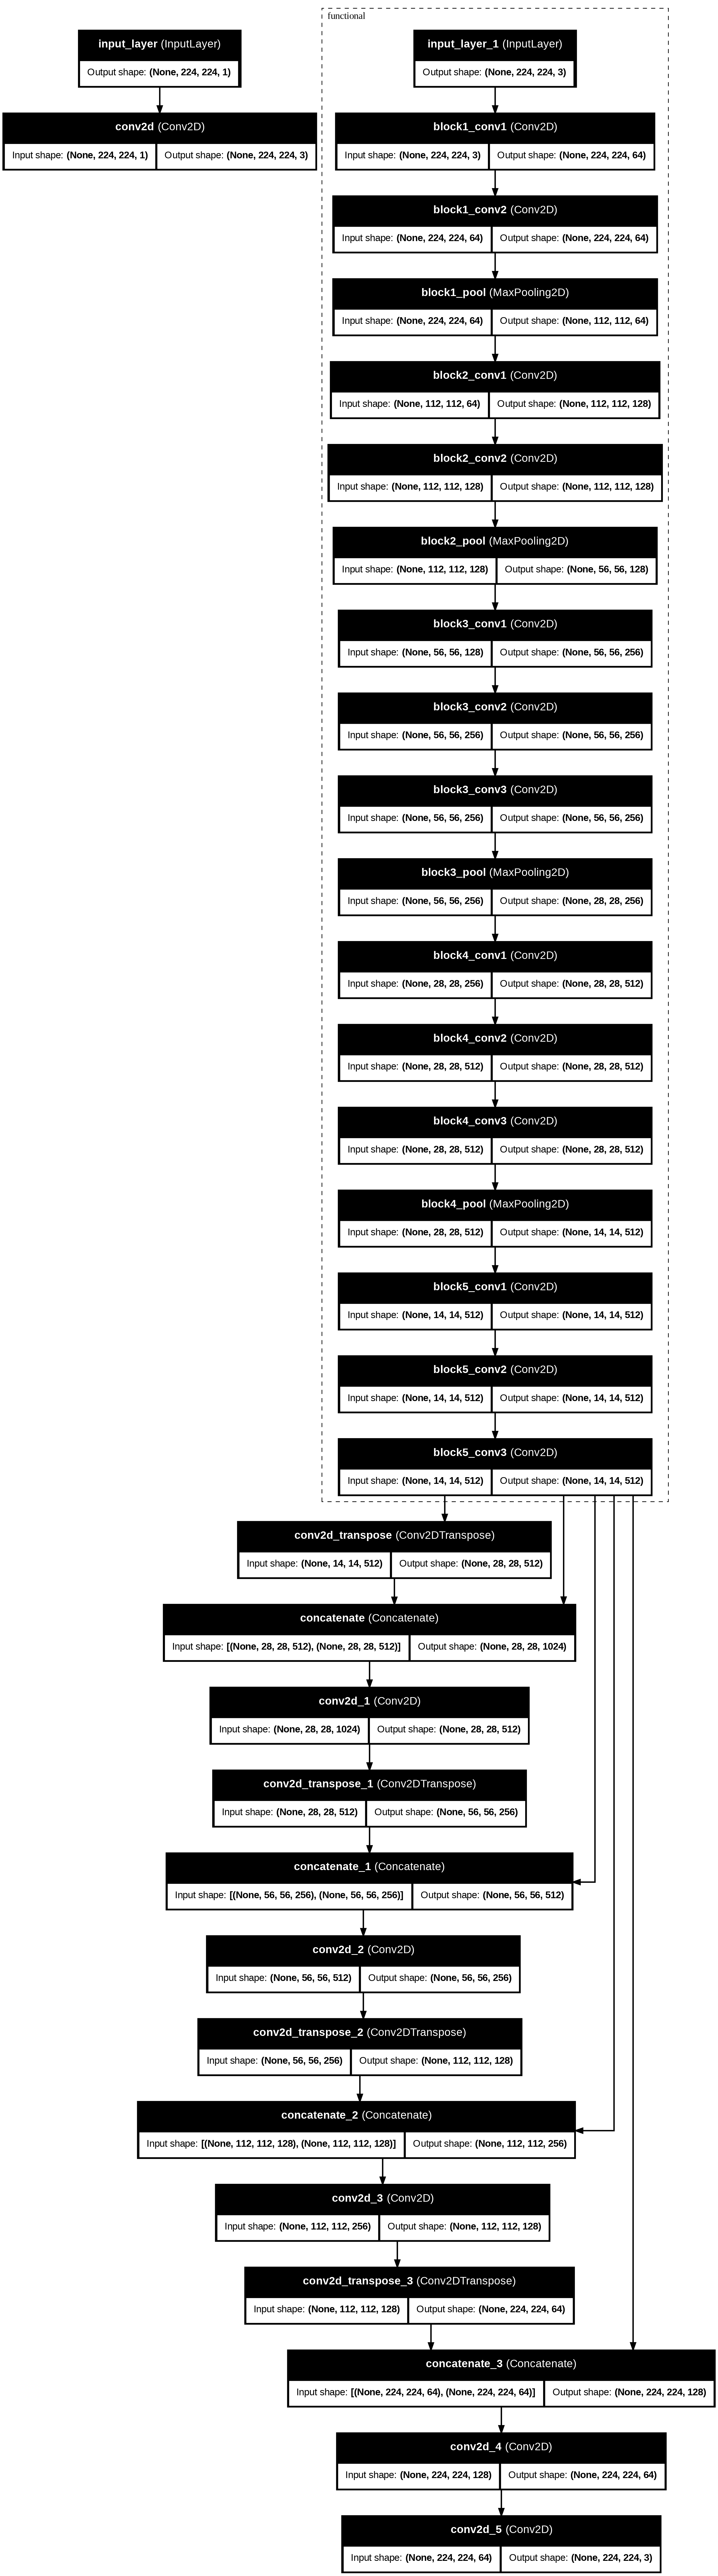

In [ ]:
from tensorflow.keras.utils import plot_model

model = build_vgg_unet()
plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True, to_file="model_architecture.png")

# Custom Loss Function: Perceptual + SSIM + Contrastive + Chroma

In [ ]:
# VGG16 sebagai feature extractor
feature_extractor = VGG16(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
feature_extractor.trainable = False

@tf.function
def extract_features(x):
    return feature_extractor(x)

@tf.keras.utils.register_keras_serializable()
def perceptual_loss(y_true, y_pred):
    y_true_features = extract_features(y_true)
    y_pred_features = extract_features(y_pred)
    perceptual_loss = tf.reduce_mean(tf.square(y_true_features - y_pred_features))
    ssim_loss = 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))
    pixel_loss = tf.reduce_mean(tf.square(y_true - y_pred))
    return 0.2 * pixel_loss + 0.3 * perceptual_loss + 0.5 * ssim_loss

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
@tf.keras.utils.register_keras_serializable()
def combined_contrastive_chroma_loss(y_true, y_pred):
    # Perceptual Loss
    y_true_feat = extract_features(y_true)
    y_pred_feat = extract_features(y_pred)
    perceptual_loss = tf.reduce_mean(tf.square(y_true_feat - y_pred_feat))

    # SSIM Loss
    ssim_loss = 1.0 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

    # Pixel L2 Loss
    pixel_loss = tf.reduce_mean(tf.square(y_true - y_pred))

    # Contrastive Perceptual Loss
    # Negatif = grayscale 3-channel
    negative = tf.image.grayscale_to_rgb(tf.image.rgb_to_grayscale(y_true))
    negative_feat = extract_features(negative)

    d_pos = tf.reduce_mean(tf.square(y_true_feat - y_pred_feat))
    d_neg = tf.reduce_mean(tf.square(y_true_feat - negative_feat))
    margin = 0.05
    contrastive_loss = tf.maximum(0.0, d_pos - d_neg + margin)

    # Chroma-weighted RGB Loss
    r_true, g_true, b_true = tf.split(y_true, 3, axis=-1)
    r_pred, g_pred, b_pred = tf.split(y_pred, 3, axis=-1)
    loss_r = tf.reduce_mean(tf.square(r_true - r_pred)) * 1.5
    loss_g = tf.reduce_mean(tf.square(g_true - g_pred)) * 1.0
    loss_b = tf.reduce_mean(tf.square(b_true - b_pred)) * 1.5
    chroma_weighted_loss = loss_r + loss_g + loss_b

    # Total Loss
    total_loss = (
        0.2 * pixel_loss +
        0.2 * perceptual_loss +
        0.2 * contrastive_loss +
        0.2 * chroma_weighted_loss +
        0.2 * ssim_loss
    )
    return total_loss

# Training model

Model dilatih menggunakan Adam dan loss gabungan di atas selama 50 epoch.

In [ ]:
# Build & compile model
model = build_vgg_unet()
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss=combined_contrastive_chroma_loss,
              metrics=["mae", "mse"])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │         30 │ input_layer_1[0]… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ [(None, 224, 224, │ 14,714,688 │ conv2d[0][0]      │
│ (Functional)        │ 64), (None, 112,  │            │                   │
│                     │ 112, 128), (None, │            │                   │
│                     │ 56, 56, 256),     │            │                   │
│                     │ (None, 28, 28,    │            │                   │
│                     │ 512), (None, 14,  │            │                   │
│                     │ 14, 512)]         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 28, 28,    │  2,359,808 │ functional[0][4]  │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 28, 28,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 1024)             │            │ functional[0][3]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 28, 28,    │  4,719,104 │ concatenate[0][0] │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 56, 56,    │  1,179,904 │ conv2d_1[0][0]    │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 56, 56,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 512)              │            │ functional[0][2]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 56, 56,    │  1,179,904 │ concatenate_1[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_2  │ (None, 112, 112,  │    295,040 │ conv2d_2[0][0]    │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 112, 112,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 256)              │            │ functional[0][1]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 112, 112,  │    295,040 │ concatenate_2[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_3  │ (None, 224, 224,  │     73,792 │ conv2d_3[0][0]    │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 224, 224,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 128)              │            │ functional[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 224, 224,  │     73,792 │ concatenate_3[0]… │
│                     │ 64)               │            │                 

 Total params: 24,891,297 (94.95 MB)

 Trainable params: 23,155,809 (88.33 MB)

 Non-trainable params: 1,735,488 (6.62 MB)

In [ ]:
# Train model
history = model.fit(
      train_ds,
      validation_data=val_ds,
      epochs=EPOCHS
    )

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - loss: 0.2872 - mae: 0.2427 - mse: 0.0915 - val_loss: 0.1847 - val_mae: 0.1898 - val_mse: 0.0513
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 597ms/step - loss: 0.1686 - mae: 0.1825 - mse: 0.0487 - val_loss: 0.1309 - val_mae: 0.1517 - val_mse: 0.0332
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 588ms/step - loss: 0.1170 - mae: 0.1378 - mse: 0.0293 - val_loss: 0.0910 - val_mae: 0.1025 - val_mse: 0.0171
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 576ms/step - loss: 0.0836 - mae: 0.0970 - mse: 0.0155 - val_loss: 0.0742 - val_mae: 0.0857 - val_mse: 0.0126
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 568ms/step - loss: 0.0702 - mae: 0.0841 - mse: 0.0124 - val_loss: 0.0693 - val_mae: 0.0839 - val_mse: 0.0124
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 563ms/step - loss: 0.0657 - mae: 0.0835 - mse: 0.0124 - val_loss: 0.0639 - val_mae: 0.0778 - val_mse: 0.0106
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 564ms/step - loss: 0.0620 - mae: 0.0796 - mse: 0.0115 -

# Evaluasi model di test dataset

In [ ]:
# Dapatkan seluruh prediksi di test set
y_true = []
y_pred = []

for x_batch, y_batch in test_ds:
    preds = model.predict(x_batch, verbose=0)
    y_true.append(y_batch.numpy())
    y_pred.append(preds)

y_true = np.concatenate(y_true, axis=0)
y_pred = np.concatenate(y_pred, axis=0)

# Hitung metrik
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

psnr_test = np.mean([psnr(gt, pr, data_range=1.0) for gt, pr in zip(y_true, y_pred)])
ssim_test = np.mean([ssim(gt, pr, data_range=1.0, channel_axis=-1) for gt, pr in zip(y_true, y_pred)])

print(f"[TEST SET] PSNR: {psnr_test:.2f} | SSIM: {ssim_test:.4f}")

[TEST SET] PSNR: 23.04 | SSIM: 0.9216


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


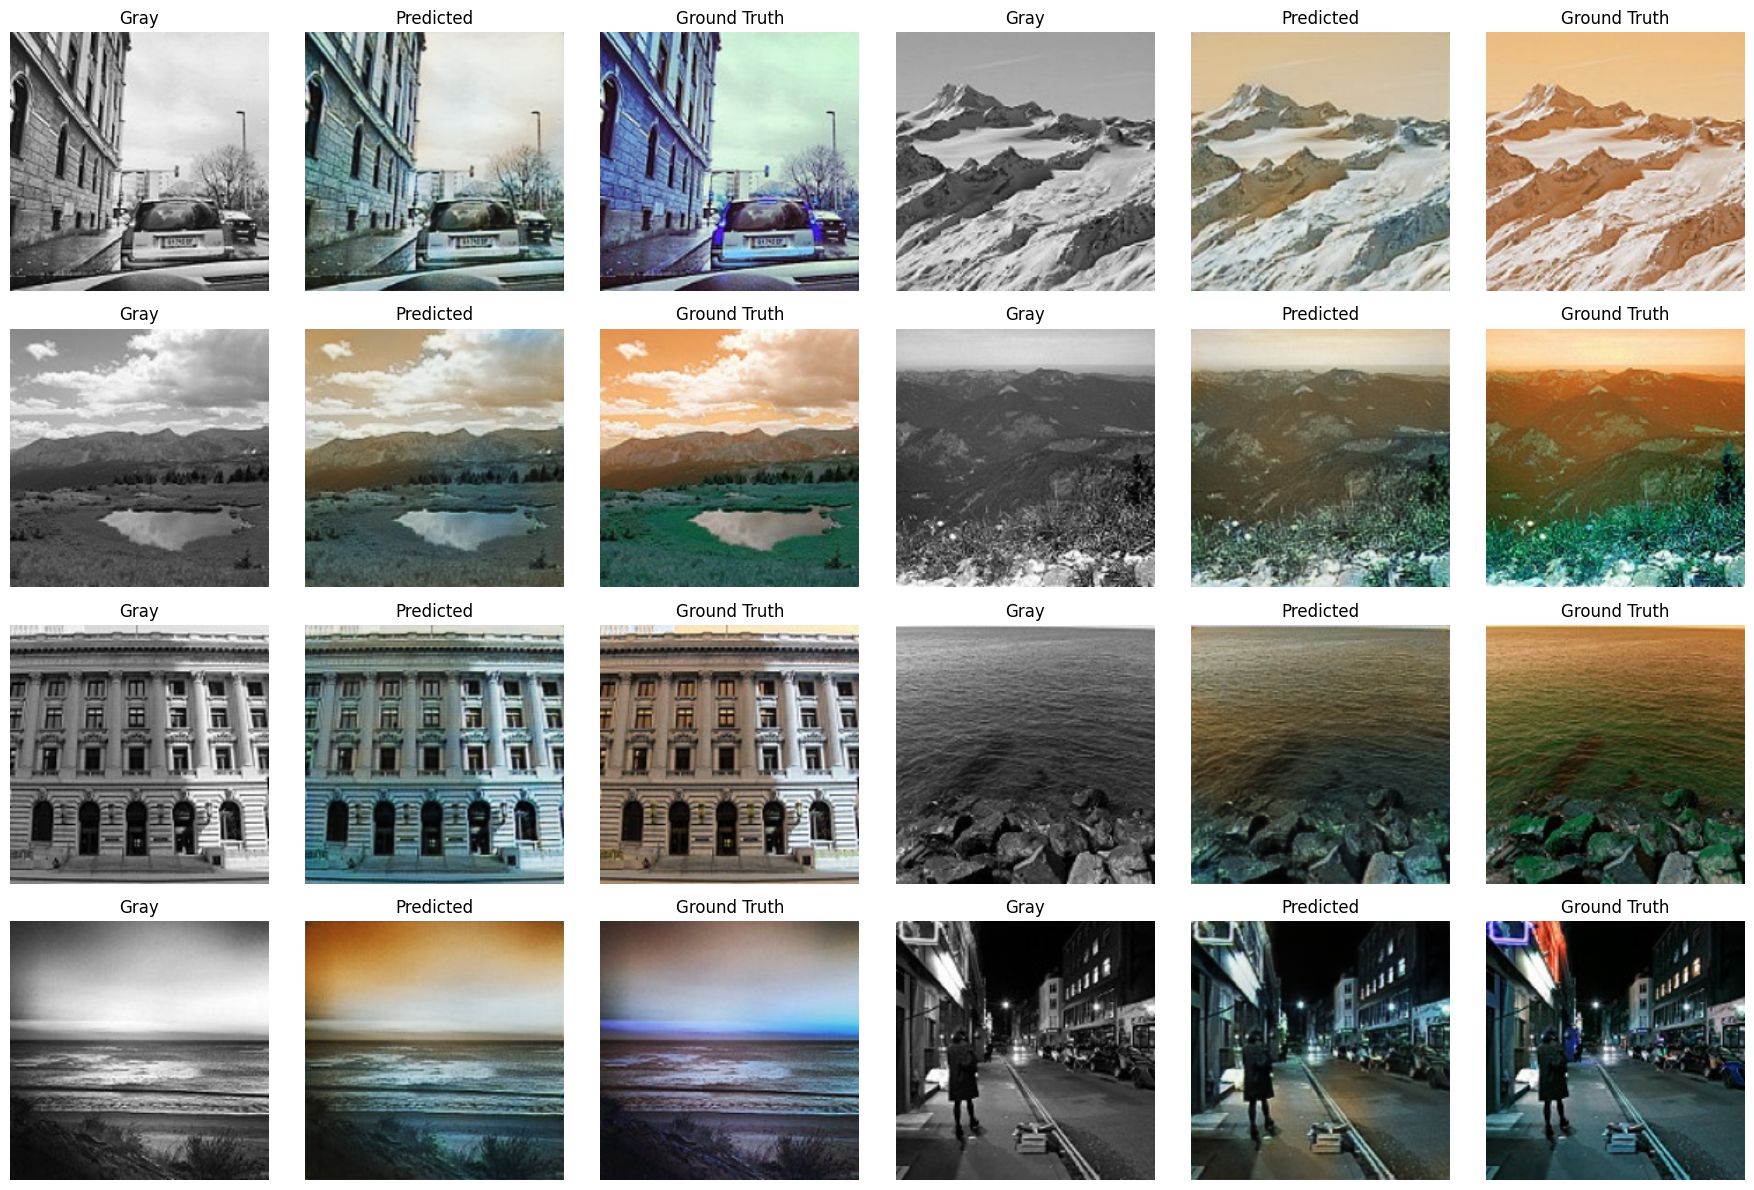

In [ ]:
for gray_batch, color_batch in test_ds.take(1):
    preds = model.predict(gray_batch)

    num_samples = min(8, len(gray_batch))
    fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(18, 12))
    fig.subplots_adjust(hspace=0.2, wspace=0.1)

    for idx in range(num_samples):
        row = idx // 2
        col_offset = (idx % 2) * 3

        axes[row, col_offset].imshow(gray_batch[idx, ..., 0], cmap='gray')
        axes[row, col_offset].set_title("Gray")
        axes[row, col_offset].axis('off')

        axes[row, col_offset + 1].imshow(preds[idx])
        axes[row, col_offset + 1].set_title("Predicted")
        axes[row, col_offset + 1].axis('off')

        axes[row, col_offset + 2].imshow(color_batch[idx])
        axes[row, col_offset + 2].set_title("Ground Truth")
        axes[row, col_offset + 2].axis('off')

    plt.tight_layout()
    plt.show()